In [1]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets, utils
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torchvision
from torchvision.models import resnet50, vgg16, alexnet, inception_v3
import os
import json
import time
from tqdm import tqdm, tqdm_notebook
import csv
from PIL import Image
metrics = {}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# --------------------获取Image和Label------------------------
def load_ground_truth(csv_filename):
    image_id_list = []
    label_tar_list = []

    with open(csv_filename) as csvfile:
        reader = csv.DictReader(csvfile, delimiter=',')
        for row in reader:
            image_id_list.append( row['ImageId'] )
            label_tar_list.append( int(row['TrueLabel'])-1 )

    return image_id_list,label_tar_list

#load image list
image_id_list,label_tar_list=load_ground_truth('./dataset/images.csv')

#------------------数据预处理-----------------------------------------

# trn = transforms.Compose([transforms.ToTensor(),
#                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
# trn1 = transforms.Compose([transforms.ToTensor()])

trn = transforms.Compose([transforms.Resize((224, 224)),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
trn1 = transforms.Compose([transforms.Resize((224, 224)),
                           transforms.ToTensor()])


# fix the random seed of pytorch and make cudnn deterministic for reproducing the same results
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

#-------------------模型选择-------------------------------------------
# load the pre-trained model
model = resnet50(pretrained=True).eval()
# model = resnet50(pretrained=True).eval()
for param in model.parameters():
    param.requires_grad=False
model.to(device)

#-------------------evaluation on Image_1000----------------------------------------
batch_size = 32
num_batches = np.int(np.ceil(len(image_id_list)/batch_size))
cnt=0
for k in tqdm_notebook(range(0,num_batches)):
    batch_size_cur=min(batch_size,len(image_id_list)-k*batch_size)
    X_ori = torch.zeros(batch_size_cur,3,224,224).to(device) 
    for i in range(batch_size_cur): 
        X_ori[i]=trn(Image.open(os.path.join('./dataset/images/'+image_id_list[k*batch_size+i])+'.png'))
    labels=torch.argmax(model(X_ori),dim=1)
    label_tar=torch.tensor(label_tar_list[k*batch_size:k*batch_size+batch_size_cur]).to(device)
    cnt += (labels == label_tar).sum().item()
acc = cnt/len(image_id_list)
print(f'Top 1 Acc: {acc * 100:4.2f}%')

cuda:0


C:\Users\86181\AppData\Local\Temp/ipykernel_6024/2108617341.py:63: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.ceil(len(image_id_list)/batch_size))
C:\Users\86181\AppData\Local\Temp/ipykernel_6024/2108617341.py:65: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(0,num_batches)):


  0%|          | 0/32 [00:00<?, ?it/s]

d:\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Top 1 Acc: 93.20%


In [2]:
imgs = torch.zeros(len(image_id_list),3,224,224)
for i in tqdm_notebook(range(len(image_id_list))):
    imgs[i] = trn1(Image.open(os.path.join('./dataset/images/'+image_id_list[i])+'.png'))


C:\Users\86181\AppData\Local\Temp/ipykernel_6024/3449788113.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(image_id_list))):


  0%|          | 0/1000 [00:00<?, ?it/s]

In [3]:
'''使用Grad-CAM得到热力图并进行二值化'''
# 得先使用normalization后的图片
from pytorch_grad_cam import GradCAM 
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

model_cam = resnet50(pretrained=True).eval().to(device)

imgs1 = imgs.clone()
suc_imgs1 = imgs1.to(device)
suc_labels1 = label_tar_list
target_layers = [model_cam.layer4[-1]]
cam = GradCAM(model=model_cam, target_layers=target_layers, use_cuda=True)

cam_map = [[None]]*len(suc_imgs1)
cam_map_binary = [[None]]*len(suc_imgs1)
for i in tqdm_notebook(range(len(suc_imgs1))):
    suc_imgs1_single = suc_imgs1[i].unsqueeze(0)
    suc_labels1_single = [ClassifierOutputTarget(suc_labels1[i])]
    cam_map[i] = cam(input_tensor=suc_imgs1_single, targets=suc_labels1_single)[0] # 不加平滑

    # 热力图的二值化
    threshold = cam_map[i].mean() #+ (cam_map[i].max()-cam_map[i].min())/4
    h,w = cam_map[i].shape
    thresh_img = cam_map[i].copy().reshape(h*w)
    for j in range(h*w):
        if thresh_img[j] < threshold:
            thresh_img[j] = 0

        
    thresh_img = thresh_img.reshape(h,w)
    cam_map_binary[i] = thresh_img
# plt.imshow(cam_map_binary[22])
# plt.show()



C:\Users\86181\AppData\Local\Temp/ipykernel_6024/3910489608.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(suc_imgs1))):


  0%|          | 0/1000 [00:00<?, ?it/s]

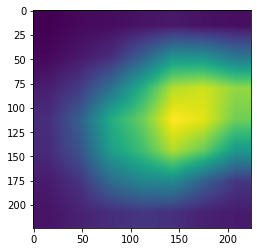

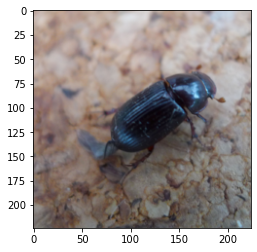

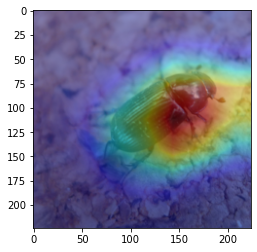

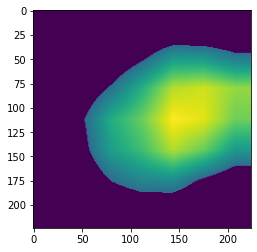

In [4]:
'''仅用来看看热力图的效果'''
from torchcam.utils import overlay_mask
from PIL import Image
import torchvision
# Transform = torchvision.transforms.Resize(224)
# image = torchvision.transforms.functional.to_pil_image(Transform(suc_imgs1[14].cpu()))
image = torchvision.transforms.functional.to_pil_image(imgs1[0])
plt.imshow(cam_map[0])
plt.show()
result = overlay_mask(image,Image.fromarray(cam_map[0]), alpha=0.6) # alpha越小，原图越淡
plt.imshow(image)
plt.show()
plt.imshow(result)
plt.show()
plt.imshow(cam_map_binary[0])
plt.show()

In [ ]:
'''white-box attacks method evalution on image1000'''
deltas = attacks - imgs
image111 = torchvision.transforms.functional.to_pil_image(deltas[0])
plt.imshow(image111)
plt.show()


batch_size = 16
num_batches = np.int(np.ceil(len(image_id_list)/batch_size))
cnt=0
for k in range(0,num_batches):
    batch_size_cur=min(batch_size,len(image_id_list)-k*batch_size)
    att_preds=torch.argmax(model(attacks[k*batch_size:k*batch_size+batch_size_cur].to(device)),dim=1)
    att_pred_temp=torch.tensor(label_tar_list[k*batch_size:k*batch_size+batch_size_cur]).to(device)
    cnt += (att_preds!= att_pred_temp).sum().item()
acc = cnt/len(image_id_list)
print(f'Top 1 Acc: {acc * 100:4.2f}%')

In [6]:
'''迁移攻击'''
model_target = vgg16(pretrained=True).eval().to(device)
deltas = attacks - imgs

trn2 = transforms.Compose([transforms.Resize((224, 224))])

batch_size = 1
num_batches = np.int(np.ceil(len(image_id_list)/batch_size))
cnt=0
for k in range(0,num_batches):
    batch_size_cur=min(batch_size,len(image_id_list)-k*batch_size)
    att_preds=torch.argmax(model_target(trn2(attacks[k*batch_size:k*batch_size+batch_size_cur]).to(device)),dim=1)
    att_pred_temp=torch.tensor(label_tar_list[k*batch_size:k*batch_size+batch_size_cur]).to(device)
    cnt += (att_preds!= att_pred_temp).sum().item()
acc = cnt/len(image_id_list)
print(f'Top 1 Acc: {acc * 100:4.2f}%')

C:\Users\86181\AppData\Local\Temp/ipykernel_6024/1505889269.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.ceil(len(image_id_list)/batch_size))


Top 1 Acc: 98.60%


### L-BFGS

In [ ]:
from attack.LBFGS import *
from tqdm import trange

att_method = LBFGS(model)
att_name = att_method.__class__.__name__
attacks = torch.zeros_like(imgs)
target_clses = []
for label_tar in label_tar_list:
    target_clses_temp = (label_tar + 1) % 10
    target_clses.append(target_clses_temp)
start = time.time()
with trange(len(imgs)) as t:
    for i in t:
        attacks[i] = att_method(imgs[i], target_clses[i])
final = time.time()

deltas = attacks - imgs
image111 = torchvision.transforms.functional.to_pil_image(attacks[0])
plt.imshow(image111)
plt.show()

batch_size = 16
num_batches = np.int(np.ceil(len(image_id_list)/batch_size))
cnt=0
for k in range(0,num_batches):
    batch_size_cur=min(batch_size,len(image_id_list)-k*batch_size)
    att_preds=torch.argmax(model(attacks[k*batch_size:k*batch_size+batch_size_cur].to(device)),dim=1)
    att_pred_temp=torch.tensor(label_tar_list[k*batch_size:k*batch_size+batch_size_cur]).to(device)
    cnt += (att_preds!= att_pred_temp).sum().item()
acc = cnt/len(image_id_list)
print(f'Top 1 Acc: {acc * 100:4.2f}%')

### FGSM

In [ ]:
from attack.FGSM import *
from tqdm import trange

att_method = FGSM(model)
att_name = att_method.__class__.__name__
attacks = torch.zeros_like(imgs)
start = time.time()
with trange(len(imgs)) as t:
    for i in t:
        attacks[i] = att_method(imgs[i], label_tar_list[i],eps=3/255)
final = time.time()

deltas = attacks - imgs
image111 = torchvision.transforms.functional.to_pil_image(attacks[0])
plt.imshow(image111)
plt.show()

batch_size = 16
num_batches = np.int(np.ceil(len(image_id_list)/batch_size))
cnt=0
for k in range(0,num_batches):
    batch_size_cur=min(batch_size,len(image_id_list)-k*batch_size)
    att_preds=torch.argmax(model(attacks[k*batch_size:k*batch_size+batch_size_cur].to(device)),dim=1)
    att_pred_temp=torch.tensor(label_tar_list[k*batch_size:k*batch_size+batch_size_cur]).to(device)
    cnt += (att_preds!= att_pred_temp).sum().item()
acc = cnt/len(image_id_list)
print(f'Top 1 Acc: {acc * 100:4.2f}%')

In [ ]:
'''FGSM + GradCAM'''
from tqdm import trange
from attack.FGSM_GradCAM import *

att_method = FGSM_GradCAM(model)
att_name = att_method.__class__.__name__
attacks = torch.zeros_like(imgs)
start = time.time()
with trange(len(imgs)) as t:
    for i in t:
        cam_map_binary_input = torch.from_numpy(cam_map_binary[i])
        attacks[i] = att_method(imgs[i], label_tar_list[i],cam_map_binary_input,eps= 3/255)
final = time.time()

deltas = attacks - imgs
image111 = torchvision.transforms.functional.to_pil_image(attacks[0])
plt.imshow(image111)
plt.show()


batch_size = 16
num_batches = np.int(np.ceil(len(image_id_list)/batch_size))
cnt=0
for k in range(0,num_batches):
    batch_size_cur=min(batch_size,len(image_id_list)-k*batch_size)
    att_preds=torch.argmax(model(attacks[k*batch_size:k*batch_size+batch_size_cur].to(device)),dim=1)
    att_pred_temp=torch.tensor(label_tar_list[k*batch_size:k*batch_size+batch_size_cur]).to(device)
    cnt += (att_preds!= att_pred_temp).sum().item()
acc = cnt/len(image_id_list)
print(f'Top 1 Acc: {acc * 100:4.2f}%')

### FGM

In [ ]:
att_method = attack.FGM(trainer.model)
att_name = att_method.__class__.__name__
attacks = torch.zeros_like(suc_imgs)
start = time.time()
with trange(len(suc_imgs)) as t:
    for i in t:
        attacks[i] = att_method(suc_imgs[i], suc_labels[i],eps=0.2)
final = time.time()

deltas = attacks - suc_imgs
norm = torch.mean(
    torch.linalg.norm(deltas.reshape(len(deltas), -1), dim = 1) \
        / torch.linalg.norm(suc_imgs.reshape(len(deltas), -1), dim = 1)
)

att_preds, att_probs = trainer.model_predict(attacks)
success_rate = (att_preds != suc_labels).sum() / len(att_preds)
print(f'{att_name}:\tSuccess Rate: {success_rate * 100:4.2f}%,  Norm: {norm:.3e},  Avg Time: {(final - start)/fig_num:.3f}s')
metrics[att_name] = {
    'success_rate': (success_rate * 100).item(),
    'norm': norm.item(),
    'time': final - start
}

In [ ]:
'''FGM+GradCAM'''
from attack.FGM_GradCAM import *
att_method = FGM_GradCAM(trainer.model)
att_name = att_method.__class__.__name__
attacks = torch.zeros_like(suc_imgs)
start = time.time()
with trange(len(suc_imgs)) as t:
    for i in t:
        cam_map_binary_input = torch.from_numpy(cam_map_binary[i])
        attacks[i] = att_method(suc_imgs[i], suc_labels[i], cam_map_binary_input,eps = 3)
final = time.time()

deltas = attacks - suc_imgs
norm = torch.mean(
    torch.linalg.norm(deltas.reshape(len(deltas), -1), dim = 1) \
        / torch.linalg.norm(suc_imgs.reshape(len(deltas), -1), dim = 1)
)

att_preds, att_probs = trainer.model_predict(attacks)
success_rate = (att_preds != suc_labels).sum() / len(att_preds)
print(f'{att_name}:\tSuccess Rate: {success_rate * 100:4.2f}%,  Norm: {norm:.3e},  Avg Time: {(final - start)/fig_num:.3f}s')
metrics[att_name] = {
    'success_rate': (success_rate * 100).item(),
    'norm': norm.item(),
    'time': final - start
}

In [ ]:
'''CW'''
from attack.CW import *
att_method = CW(model,cuda=0)
att_name = att_method.__class__.__name__
attacks = torch.zeros_like(imgs)
start = time.time()
attacks = att_method(imgs, label_tar_list,max_iter=3)
final = time.time()

deltas = attacks - imgs
image111 = torchvision.transforms.functional.to_pil_image(attacks[0])
plt.imshow(image111)
plt.show()

batch_size = 16
num_batches = np.int(np.ceil(len(image_id_list)/batch_size))
cnt=0
for k in range(0,num_batches):
    batch_size_cur=min(batch_size,len(image_id_list)-k*batch_size)
    att_preds=torch.argmax(model(attacks[k*batch_size:k*batch_size+batch_size_cur].to(device)),dim=1)
    att_pred_temp=torch.tensor(label_tar_list[k*batch_size:k*batch_size+batch_size_cur]).to(device)
    cnt += (att_preds!= att_pred_temp).sum().item()
acc = cnt/len(image_id_list)
print(f'Top 1 Acc: {acc * 100:4.2f}%')

### I-FGSM / BIM

In [ ]:
from tqdm import trange
from attack.IFGSM import *

att_method = IFGSM(model)
att_name = att_method.__class__.__name__
attacks = torch.zeros_like(imgs)
start = time.time()
with trange(len(imgs)) as t:
    for i in t:
        attacks[i] = att_method(imgs[i], label_tar_list[i],max_iter=5,eps=16/255)
final = time.time()

deltas = attacks - imgs
image111 = torchvision.transforms.functional.to_pil_image(attacks[0])
plt.imshow(image111)
plt.show()

batch_size = 16
num_batches = np.int(np.ceil(len(image_id_list)/batch_size))
cnt=0
for k in range(0,num_batches):
    batch_size_cur=min(batch_size,len(image_id_list)-k*batch_size)
    att_preds=torch.argmax(model(attacks[k*batch_size:k*batch_size+batch_size_cur].to(device)),dim=1)
    att_pred_temp=torch.tensor(label_tar_list[k*batch_size:k*batch_size+batch_size_cur]).to(device)
    cnt += (att_preds!= att_pred_temp).sum().item()
acc = cnt/len(image_id_list)
print(f'Top 1 Acc: {acc * 100:4.2f}%')

100%|██████████| 1000/1000 [02:15<00:00,  7.40it/s]


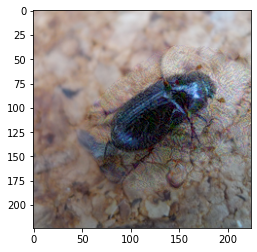

C:\Users\86181\AppData\Local\Temp/ipykernel_19112/4095413422.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.ceil(len(image_id_list)/batch_size))


Top 1 Acc: 99.90%


In [14]:
'''I-FGSM + GradCAM'''
from tqdm import trange
from attack.IFGSM_GradCAM import *

att_method = IFGSM_GradCAM(model)
att_name = att_method.__class__.__name__
attacks = torch.zeros_like(imgs)
start = time.time()
with trange(len(imgs)) as t:
    for i in t:
        cam_map_binary_input = torch.from_numpy(cam_map_binary[i])
        attacks[i] = att_method(imgs[i], label_tar_list[i],cam_map_binary_input,max_iter=5,eps=16/255)
final = time.time()

deltas = attacks - imgs
image111 = torchvision.transforms.functional.to_pil_image(attacks[0])
plt.imshow(image111)
plt.show()

batch_size = 16
num_batches = np.int(np.ceil(len(image_id_list)/batch_size))
cnt=0
for k in range(0,num_batches):
    batch_size_cur=min(batch_size,len(image_id_list)-k*batch_size)
    att_preds=torch.argmax(model(attacks[k*batch_size:k*batch_size+batch_size_cur].to(device)),dim=1)
    att_pred_temp=torch.tensor(label_tar_list[k*batch_size:k*batch_size+batch_size_cur]).to(device)
    cnt += (att_preds!= att_pred_temp).sum().item()
acc = cnt/len(image_id_list)
print(f'Top 1 Acc: {acc * 100:4.2f}%')

100%|██████████| 1000/1000 [06:39<00:00,  2.50it/s]


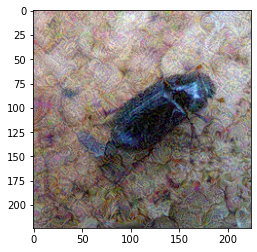

C:\Users\86181\AppData\Local\Temp/ipykernel_6024/1743768594.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.ceil(len(image_id_list)/batch_size))


Top 1 Acc: 100.00%


In [4]:
'''I-FGSM + GradCAM_attention'''
from tqdm import trange
from attack.IFGSM_GradCAM_new import *

att_method = IFGSM_GradCAM_new(model)
att_name = att_method.__class__.__name__
attacks = torch.zeros_like(imgs)
start = time.time()
with trange(len(imgs)) as t:
    for i in t:
        cam_map_input = torch.from_numpy(cam_map[i])
        attacks[i] = att_method(imgs[i], label_tar_list[i], cam_map_input, cam, max_iter=5, eps=16/255)
final = time.time()

deltas = attacks - imgs
image111 = torchvision.transforms.functional.to_pil_image(attacks[0])
plt.imshow(image111)
plt.show()

batch_size = 16
num_batches = np.int(np.ceil(len(image_id_list)/batch_size))
cnt=0
for k in range(0,num_batches):
    batch_size_cur=min(batch_size,len(image_id_list)-k*batch_size)
    att_preds=torch.argmax(model(attacks[k*batch_size:k*batch_size+batch_size_cur].to(device)),dim=1)
    att_pred_temp=torch.tensor(label_tar_list[k*batch_size:k*batch_size+batch_size_cur]).to(device)
    cnt += (att_preds!= att_pred_temp).sum().item()
acc = cnt/len(image_id_list)
print(f'Top 1 Acc: {acc * 100:4.2f}%')

### PGD

100%|██████████| 1000/1000 [01:58<00:00,  8.46it/s]


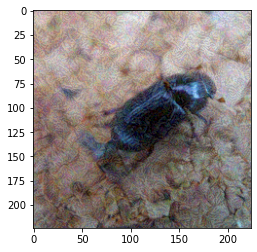

C:\Users\86181\AppData\Local\Temp/ipykernel_19112/2592135738.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.ceil(len(image_id_list)/batch_size))


Top 1 Acc: 100.00%


In [4]:
from attack.PGD import *
from tqdm import trange

att_method = PGD(model)
att_name = att_method.__class__.__name__
attacks = torch.zeros_like(imgs)
start = time.time()
with trange(len(imgs)) as t:
    for i in t:
        attacks[i] = att_method(imgs[i], label_tar_list[i],eps=16/255)
final = time.time()

deltas = attacks - imgs
image111 = torchvision.transforms.functional.to_pil_image(attacks[0])
plt.imshow(image111)
plt.show()

batch_size = 16
num_batches = np.int(np.ceil(len(image_id_list)/batch_size))
cnt=0
for k in range(0,num_batches):
    batch_size_cur=min(batch_size,len(image_id_list)-k*batch_size)
    att_preds=torch.argmax(model(attacks[k*batch_size:k*batch_size+batch_size_cur].to(device)),dim=1)
    att_pred_temp=torch.tensor(label_tar_list[k*batch_size:k*batch_size+batch_size_cur]).to(device)
    cnt += (att_preds!= att_pred_temp).sum().item()
acc = cnt/len(image_id_list)
print(f'Top 1 Acc: {acc * 100:4.2f}%')

100%|██████████| 1000/1000 [00:31<00:00, 31.84it/s]


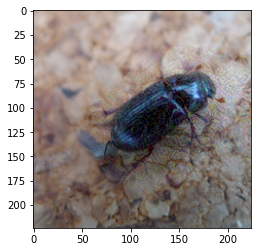

C:\Users\86181\AppData\Local\Temp/ipykernel_19112/3076442566.py:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  num_batches = np.int(np.ceil(len(image_id_list)/batch_size))


Top 1 Acc: 99.90%


In [10]:
'''将二值化的热力图和PGD进行结合，进行局部白盒攻击'''
from attack.PGD_GradCAM import *
att_method = PGD_GradCAM(model)
att_name = att_method.__class__.__name__
attacks = torch.zeros_like(imgs)
start = time.time()
with trange(len(imgs)) as t:
    for i in t:
        cam_map_binary_input = torch.from_numpy(cam_map_binary[i])
        attacks[i] = att_method(imgs[i], label_tar_list[i],cam_map_binary_input)
final = time.time()

deltas = attacks - imgs
image111 = torchvision.transforms.functional.to_pil_image(attacks[0])
plt.imshow(image111)
plt.show()

batch_size = 16
num_batches = np.int(np.ceil(len(image_id_list)/batch_size))
cnt=0
for k in range(0,num_batches):
    batch_size_cur=min(batch_size,len(image_id_list)-k*batch_size)
    att_preds=torch.argmax(model(attacks[k*batch_size:k*batch_size+batch_size_cur].to(device)),dim=1)
    att_pred_temp=torch.tensor(label_tar_list[k*batch_size:k*batch_size+batch_size_cur]).to(device)
    cnt += (att_preds!= att_pred_temp).sum().item()
acc = cnt/len(image_id_list)
print(f'Top 1 Acc: {acc * 100:4.2f}%')

### MIFGSM

In [ ]:
att_method = attack.MIFGSM(trainer.model)
att_name = att_method.__class__.__name__
attacks = torch.zeros_like(suc_imgs)
start = time.time()
with trange(len(suc_imgs)) as t:
    for i in t:
        attacks[i] = att_method(suc_imgs[i], suc_labels[i])
final = time.time()

deltas = attacks - suc_imgs
norm = torch.mean(
    torch.linalg.norm(deltas.reshape(len(deltas), -1), dim = 1) \
        / torch.linalg.norm(suc_imgs.reshape(len(deltas), -1), dim = 1)
)

att_preds, att_probs = trainer.model_predict(attacks)
success_rate = (att_preds != suc_labels).sum() / len(att_preds)
print(f'{att_name}:\tSuccess Rate: {success_rate * 100:4.2f}%,  Norm: {norm:.3e},  Avg Time: {(final - start)/fig_num:.3f}s')
metrics[att_name] = {
    'success_rate': (success_rate * 100).item(),
    'norm': norm.item(),
    'time': final - start
}

### NIFGSM

In [ ]:
att_method = attack.NIFGSM(trainer.model)
att_name = att_method.__class__.__name__
attacks = torch.zeros_like(suc_imgs)
start = time.time()
with trange(len(suc_imgs)) as t:
    for i in t:
        attacks[i] = att_method(suc_imgs[i], suc_labels[i])
final = time.time()

deltas = attacks - suc_imgs
norm = torch.mean(
    torch.linalg.norm(deltas.reshape(len(deltas), -1), dim = 1) \
        / torch.linalg.norm(suc_imgs.reshape(len(deltas), -1), dim = 1)
)

att_preds, att_probs = trainer.model_predict(attacks)
success_rate = (att_preds != suc_labels).sum() / len(att_preds)
print(f'{att_name}:\tSuccess Rate: {success_rate * 100:4.2f}%,  Norm: {norm:.3e},  Avg Time: {(final - start)/fig_num:.3f}s')
metrics[att_name] = {
    'success_rate': (success_rate * 100).item(),
    'norm': norm.item(),
    'time': final - start
}

### Step-LL

In [ ]:
att_method = attack.StepLL(trainer.model)
att_name = att_method.__class__.__name__
attacks = torch.zeros_like(suc_imgs)
start = time.time()
with trange(len(suc_imgs)) as t:
    for i in t:
        attacks[i] = att_method(suc_imgs[i], 10, eps = 0.05)
final = time.time()

deltas = attacks - suc_imgs
norm = torch.mean(
    torch.linalg.norm(deltas.reshape(len(deltas), -1), dim = 1) \
        / torch.linalg.norm(suc_imgs.reshape(len(deltas), -1), dim = 1)
)

att_preds, att_probs = trainer.model_predict(attacks)
success_rate = (att_preds != suc_labels).sum() / len(att_preds)
print(f'{att_name}:\tSuccess Rate: {success_rate * 100:4.2f}%,  Norm: {norm:.3e},  Avg Time: {(final - start)/fig_num:.3f}s')
metrics[att_name] = {
    'success_rate': (success_rate * 100).item(),
    'norm': norm.item(),
    'time': final - start
}

## IterLL

In [ ]:
att_method = attack.IterLL(trainer.model)
att_name = att_method.__class__.__name__
attacks = torch.zeros_like(suc_imgs)
start = time.time()
with trange(len(suc_imgs)) as t:
    for i in t:
        attacks[i] = att_method(suc_imgs[i], 10)
final = time.time()

deltas = attacks - suc_imgs
norm = torch.mean(
    torch.linalg.norm(deltas.reshape(len(deltas), -1), dim = 1) \
        / torch.linalg.norm(suc_imgs.reshape(len(deltas), -1), dim = 1)
)

att_preds, att_probs = trainer.model_predict(attacks)
success_rate = (att_preds != suc_labels).sum() / len(att_preds)
print(f'{att_name}:\tSuccess Rate: {success_rate * 100:4.2f}%,  Norm: {norm:.3e},  Avg Time: {(final - start)/fig_num:.3f}s')
metrics[att_name] = {
    'success_rate': (success_rate * 100).item(),
    'norm': norm.item(),
    'time': final - start
}

### Deep Fool

In [ ]:
att_method = attack.DeepFool(trainer.model)
att_name = att_method.__class__.__name__
attacks = torch.zeros_like(suc_imgs)
start = time.time()
with trange(len(suc_imgs)) as t:
    for i in t:
        attacks[i] = att_method(suc_imgs[i], 10)
final = time.time()

deltas = attacks - suc_imgs
norm = torch.mean(
    torch.linalg.norm(deltas.reshape(len(deltas), -1), dim = 1) \
        / torch.linalg.norm(suc_imgs.reshape(len(deltas), -1), dim = 1)
)

att_preds, att_probs = trainer.model_predict(attacks)
success_rate = (att_preds != suc_labels).sum() / len(att_preds)
print(f'{att_name}:\tSuccess Rate: {success_rate * 100:4.2f}%,  Norm: {norm:.3e},  Avg Time: {(final - start)/fig_num:.3f}s')
metrics[att_name] = {
    'success_rate': (success_rate * 100).item(),
    'norm': norm.item(),
    'time': final - start
}

### One Pixel

In [ ]:
# att_method = attack.OnePixel(trainer.model)
# att_name = att_method.__class__.__name__
# attacks = torch.zeros_like(suc_imgs)
# start = time.time()
# with trange(len(suc_imgs)) as t:
#     for i in t:
#         attacks[i] = att_method(suc_imgs[i], suc_labels[i], 100, 400)
# final = time.time()

# deltas = attacks - suc_imgs
# norm = torch.mean(
#     torch.linalg.norm(deltas.reshape(len(deltas), -1), dim = 1) \
#         / torch.linalg.norm(suc_imgs.reshape(len(deltas), -1), dim = 1)
# )

# att_preds, att_probs = trainer.model_predict(attacks)
# success_rate = (att_preds != suc_labels).sum() / len(att_preds)
# print(f'{att_name}:\tSuccess Rate: {success_rate * 100:4.2f}%,  Norm: {norm:.3e},  Avg Time: {(final - start)/fig_num:.3f}s')
# metrics[att_name] = {
#     'success_rate': success_rate * 100,
#     'norm': norm,
#     'time': final - start
# }

In [ ]:
metrics_df = pd.DataFrame(metrics)

In [ ]:
metrics_df

In [ ]:
metrics_df.to_csv('./results/attack_metrics.csv')